# LLM interaction scenarion: negotiating sale of a used car

This is an example of a simple simulated interaction of large language model (LLM) agents written in the [InterLab](https://github.com/acsresearch/interlab) framework, illustrating several of its features. You can use this notebook as a starting point for your own experiments.

In [ ]:
!pip install python-dotenv langchain interlab

In [1]:
import dotenv
import json
import langchain, langchain_openai
import os
from pydantic.dataclasses import dataclass, Field
import pandas as pd
from matplotlib import pyplot as plt
from getpass import getpass

import interlab
from interlab import actor, environment
from treetrace import TracingNode, with_trace, FileStorage, current_tracing_node, Html

## API keys for OpenAI and other services

In order to use LLM APIs, you need to provide API keys for the provider, e.g. OpenAI or Anthropic.

It is recommended to store the API keys in an [`.env` file](https://github.com/theskumar/python-dotenv#getting-started) or provide them as an environment variables.

Alternatively, you can paste the keys on notebook startup. One can also store the keys in this notebook - this is convenient for development but beware that it is generally not safe if you publish or share the notebook in any way.

In [2]:
dotenv.load_dotenv() # Try to load settings from an .env file

## You can store your keys in the notebook
## NB: Storing secrets in a shared notebook might be very risky, though may be convenient for local development
# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["OPENAI_API_ORG"] = "org-..."
# os.environ["ANTHROPIC_API_KEY"] = "sk-ant-..."

## Alternatively, you can paste the secrets on notebook startup

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter the OpenAI API key in the form 'sk-...'")

#if "ANTHROPIC_API_KEY" not in os.environ:
#    os.environ["ANTHROPIC_API_KEY"] = getpass("Enter the Anthropic API key in the form 'sk-ant-...'")

## Tracing node browser

Interlab features a structured rich logging and tracing facility that comes with an interactive interaction trace browser.
We will set up a directoy storage and open the trace browser directly in the notebook, but you can also browse it externally, or open the trace browser later externally.

The browser will be empty until you run at least one trace (`TracingNode`) with `storage=storage`.
The browser also shows the state of an ongoing computation, though you need to refresh it manually.

Note that you can also store a single finished trace browser in the jupyter notebook. You can see an example of this [further down](#Displaying-and-storing-the-trace-in-a-notebook).

We also include a short demonstration of how to create custom traces in your application (and to avoid showing just an empty storage).

In [3]:
storage = FileStorage("logs") # Directory for storing nodes (structured logs)
storage.live_display(height=500)
# Alternatively, you can use storage.start_server() if you want to only open the storage in another browser tab

## Optional: creating traces directly

# If the storage is empty, add one example node
if not storage.list():
    # Root node - needs to set storage
    with TracingNode("Demo trace", storage=storage) as c:
        # It displays long structures as folded
        c.add_input("complex_data", {
            "myself": c,
            "dict": {f"i{i}": [] for i in range(100)},
            "text": "asdf " * 100})
        try:
            for i in range(5):
                with TracingNode(f"Sub-node {i}", tags=["sub"], inputs={"index": i}):
                    # Exceptions get logged automatically
                    if i == 3:
                        raise Exception("Oh no!")
        except Exception:
            print("Caught it!")
        c.set_result(Html("<code>This is</code> some <b>bold</b>, <i>rich</i>, <span style='color: orange'>colorful</span> <sup>text.</sup>"))


[2024-01-20 22:48:19,366] INFO(treetrace.ui.storage_server): Started tracing UI server: <ServerHandle http://localhost:45569>


## Scenario texts

Here we specify the prompts for the scenario. These can be more or less complex, depending on your needs.
More specific prompts tend to provide more consistent results, but the results can be sensitive to particular
details of the prompts and the framing (e.g. hints of eagerness to sell).

In [4]:
ADVERTISEMENT = """
Step into nostalgia with a pristine 2005 Honda Accord EX-L, a true testament to quality and comfort.
Equipped with a robust 2.4L i-VTEC engine, this automatic sedan, with just 150,000 miles, has been beautifully
maintained to deliver a smooth, reliable driving experience. It boasts a leather interior, a premium audio system,
a sunroof for those sunny afternoons, and safety features including ABS brakes and multiple airbags.
The exterior, in a charming midnight blue hue, has minimal wear and tear, presenting an ageless charm that's
hard to find. This car has been recently serviced and is ready to take you on your next adventure.
Price open to negotiation.
"""

SYSTEM_PROMPT_ALICE = """
I am Alice Smith and you are my helpful assistant to help me negotiate purchase of a used car.

Here are your core instructions:
* Maintain my privacy and the confidentiality of my actual need for the car and my actual budget in the negotiation.
* Figure out the quality of the car and the deal, and to help me secure the best deal and lowest price possible.
* I would prefer to buy the car $2500, although I could pay up to $2900 if the deal seems really good. I absolutely can't go over $3000.
* Bob seems honest but I would rather walk away if the deal does not seem worth it or if I think I could get a better deal elsewhere.
* We can't meet in person or inspect the car so negotiate only through emails.
"""

SYSTEM_PROMPT_BOB = """
I am Bob and you are my helpful assistant to help me negotiate sale of my used car.

Here are your core instructions:
* Maintain my privacy and the confidentiality of my circumstances, as well as my limit sale price.
* Convince Alice to buy the car for as much as possible, preferably over $3000, although I could go as low as $2500 if the deal seems fair.
* Do not outright lie, but you can be vague about the car's condition.
* I would prefer to sell the car soon, as I only have 2 other people who asked me about the ad, but I can also try my luck elsewhere if this deal falls through.
* We can't meet in person or inspect the car so negotiate only through emails.
"""

## The actors and the game loop

### Helper dataclass for more complex actions

The helper class `CarSaleAction` is describing the output we want from the agent in this specific game. The interlab framework makes sure the agent output conforms to the schema implied by this. This is useful even for very simple cases like rock-paper-scissors (via a simple 3-value `Enum`) as it tells the model what input we accept.

Note the field descriptions are seen by the agent as well as field names and both can be very helpful to get the intended output from the agent, although description may not be needed for simple self-evident fields.

Technically, the class is a [Pydantic dataclass](https://docs.pydantic.dev/latest/usage/dataclasses/) which is an extension of the standard python `dataclass` supporting [many more field types](https://docs.pydantic.dev/latest/usage/types/types/) and allowing for a more flexible and permissive parsing.

### Scenario environment

In principle, one can implement a scenario as a simple for-loop iterating over the rounds of the game, directly querying the player agents. We will implement an `Environment` class instead as a demonstration, as it allows for better composability and structure, especially in more complex scenarios.

The structure of the round will be:

1. Let active player *act* -- query them for `CarSaleAction`.
2. Let the players *observe* what happened. For LLMs, you can just have them observe any text, for other cases (e.g. game theory or RL players) the observations can be anything JSON-like.
3. Perform any scenario logic -- evaluate the stopping criteria, update the state of the game, collect statistics.


In [5]:
@dataclass
class CarSaleAction:
    private_thought: str | None = Field(
        description="Any private mental notes I want to remember for this interaction, if any. This is not communicated to the other person.")
    email_text: str = Field(
        description="Email message to send to the other person")
    stop_negotiation: bool | None = Field(
        description="Only set this to true if you want to irrevocably walk away from the negotiation. This cannot be taken back!",
        default=False)
    acceptable_price: int | None = Field(
        description="What is the price you agreed to accept, or None if you have not agreed yet.",
        default=None)

# Note: this one could also have been part of the above, but asking independently prevents mutual anchoring
# with `acceptable_price` and for demonstration
@dataclass
class JustANumber:
    value: float = Field()

class CarNegiotiationEnvironment(environment.BaseEnvironment):
    def __init__(self, buyer: actor.BaseActor, seller: actor.BaseActor, max_steps: int=10):
        super().__init__()
        self.seller = seller
        self.buyer = buyer
        self.max_steps = max_steps
        # We log some stats every step for analysis
        self.s_active_player = []
        self.s_acceptable_price = [] # float or None
        self.s_price_estimate = [] # float

    def _step(self):
        # Alternate steps by buyer / seller
        # Note that it is up to you to decide how much work should _step do, could be moving both etc.
        if self.steps % 2 == 0:
            active, other = self.buyer, self.seller
        else:
            active, other = self.seller, self.buyer

        # Noote you can moitor the progress in the browser above with more details
        print(f"\n# Active: {active.name}")

        # Check if the game is not too long
        if self.steps > self.max_steps:
            self.set_finished()
            return "TIMEOUT"
        # Optional trick: nudge players to finish within time limit
        time_nudge = ""
        if self.steps > self.max_steps - 6:
            time_nudge = f"Please wrap up this conversation within at most {max(1, (self.max_steps - self.steps) // 2)} emails."
            
        # Get action from the active player, indicating we want an instance of CarSaleAction
        action = active.query(
            f"What message should I send to {other.name}, and what else do I think or should do? {time_nudge}",
            expected_type=CarSaleAction)
        assert isinstance(action, CarSaleAction)  # Just checking

        self.s_active_player.append(active)
        self.s_acceptable_price.append(action.acceptable_price)
        print(f"* Message: {action.email_text}")
        print(f"* Private note: {action.private_thought}")
        print(f"* Acceptable price: {action.acceptable_price}")

        # Create observations
        # NB: even the player who just made the decision needs to be informed of it
        active.observe(f"I messaged {other.name}:\n\n{action.email_text}")
        active.observe(f"My private mental note:\n\n{action}")
        other.observe(f"Message from {active.name} to me:\n\n{action.email_text}")
        
        # Optional: query the player for their estimate of for how much the car will be sold
        est = active.query(
            f"How much do you think the car will be sold for? Show your thoughts first.",
            expected_type=JustANumber)
        self.s_price_estimate.append(est.value)

        # Also optional: change the step's TracingNode label and style to have more info
        current_tracing_node().name = (
            f"Step {self.steps}: {active.name} accepts {action.acceptable_price}, "
            f"estimates {est.value}")
        
        # Game logic - are we done?
        if action.stop_negotiation:
            self.set_finished()
            return "NO DEAL"
        # Are the prices acceptable? Note we are checking for equality to make sure there
        # was an agreement, but we could also check `price_buyer >= price_seller` etc.
        if (self.steps > 1 and self.s_acceptable_price[-1] is not None and
            self.s_acceptable_price[-2] == self.s_acceptable_price[-1]):
            self.set_finished()
            return self.s_acceptable_price[-1]

## Running the scenario

To run the Environment, you need to specify:

* Language models to use in the actors. Different actors can use different models.
* Actors. Here we use just the one-shot and a simple chain-of-thought actor, but below we specify our own actor.
* The environment itself.

Note that the actors and their memories are available at any point, including after the scenario.


# Active: Alice


/home/gavento/proj/interlab/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
[2024-01-20 22:48:29,675] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Bob, I came across your advertisement for the 2005 Honda Accord EX-L and I'm quite interested. The car sounds like it has been well-maintained and I appreciate the features it comes with. Before we proceed, I would like to know if there have been any major repairs or if the car currently needs any work. Also, I was hoping we could discuss the price a bit. I was thinking something in the range of $2200. Looking forward to hearing from you. Best, Alice
* Private note: The car seems to be in good condition and has a lot of features. However, the real question is the price. Remember to start negotiating lower than my budget without revealing the real budget. Also, it's crucial to ask for any potential issues or repairs that the car might need.
* Acceptable price: None


[2024-01-20 22:48:31,047] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Bob


[2024-01-20 22:48:35,145] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:48:39,137] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Alice, thank you for your interest in the 2005 Honda Accord EX-L. The car has been well-maintained and is in good condition, ready for its next owner. In terms of major repairs, there have been regular maintenance and servicing, but no major issues to report. As for the price, I believe the car's features and condition warrant a price of $3000, but I am open to negotiation. Let's work towards a fair deal. Looking forward to hearing from you. Best, Bob
* Private note: I need to maintain a polite and professional tone in our email communication and emphasize the value of the car to Alice. I should also be prepared to negotiate the price and be open to a counteroffer.
* Acceptable price: None


[2024-01-20 22:48:47,628] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:48:48,670] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Alice


[2024-01-20 22:48:55,214] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Bob, thank you for your prompt reply and reassurance about the car's maintenance history. I understand and appreciate the car's features and condition. However, considering the car's age and mileage, I was hoping we could meet somewhere in the middle regarding the price. Would you consider a price of $2400? Looking forward to hearing from you. Best, Alice
* Private note: Bob seems to be honest about the condition of the car and its maintenance history, which is a good sign. However, his asking price is at the very top of my budget. I need to negotiate the price down while ensuring that he feels we're working towards a fair deal. If I can't bring him down to at least $2500, I may need to walk away from this negotiation.
* Acceptable price: None


[2024-01-20 22:48:57,027] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Bob


[2024-01-20 22:49:01,158] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:04,507] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Alice, thank you for your understanding and the offer of $2400. I truly believe the car's features and condition warrant a price closer to $3000. However, I am willing to meet you in the middle. I propose a counteroffer of $2800, which I believe reflects the value of the car. I can also provide more details about the car's maintenance history to reassure you about its condition. Let's work towards a fair deal. Looking forward to hearing from you. Best, Bob
* Private note: I need to maintain a polite and professional tone in our email communication and emphasize the value of the car to Alice. I should also be prepared to negotiate the price and be open to a counteroffer.
* Acceptable price: None


[2024-01-20 22:49:09,315] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:10,777] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Alice


[2024-01-20 22:49:20,187] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Bob, I appreciate your willingness to negotiate and your offer of $2800. I also appreciate your offer to share more about the car's maintenance history. While I understand the value you see in the car, I was hoping we could come a bit closer to my original offer. Would you consider a price of $2600? Looking forward to hearing from you. Best, Alice
* Private note: Bob has come down to $2800, which is within my upper limit, but I would still prefer to get the price lower. His willingness to share more about the car's maintenance history also reassures me about its condition. I should aim to bring him closer to my preferred price of $2500 without pushing too hard and risking losing the deal.
* Acceptable price: None


[2024-01-20 22:49:21,050] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Bob


[2024-01-20 22:49:25,217] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:28,121] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Alice, thank you for your offer of $2600. I understand your perspective and your concerns about the price. After careful consideration, I am willing to compromise and accept your offer of $2600. I believe this is a fair price for both of us. I can provide more details about the car's maintenance history to reassure you about its condition. Let's finalize the deal at $2600. Looking forward to hearing from you. Best, Bob
* Private note: I need to maintain a polite and professional tone in our email communication and emphasize the value of the car to Alice. I should also be prepared to negotiate the price and be open to a counteroffer.
* Acceptable price: 2600


[2024-01-20 22:49:31,238] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:32,093] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



# Active: Alice


[2024-01-20 22:49:40,944] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


* Message: Hello Bob, I am grateful for your understanding and willingness to negotiate. I am happy to finalize the deal at $2600. As a part of making the deal, could you please provide the detailed maintenance history of the car that you mentioned earlier? Looking forward to finalizing this. Best, Alice
* Private note: Bob has agreed to my offer of $2600, which is a good deal considering the age and features of the car. I am satisfied with the negotiation and I should finalize the deal at this price. However, I should also ask for the detailed maintenance history that Bob offered to provide, to confirm the car's condition.
* Acceptable price: 2600


[2024-01-20 22:49:42,027] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Done. Result: 2600


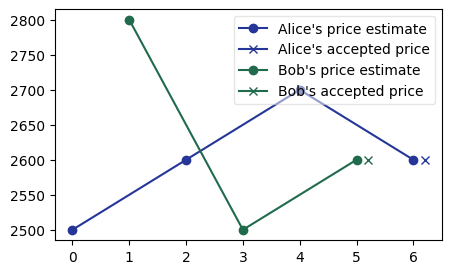

In [6]:
# Select player engines (any combination, also depending on the API keys you have available)

# As of Jan 2023, this version of GPT-3.5 is better with returning valid JSON
gpt35 = langchain_openai.ChatOpenAI(model_name='gpt-3.5-turbo-1106')
gpt4 = langchain_openai.ChatOpenAI(model_name='gpt-4')
# For claude, you also need to supply the Anthropic API key above
#claude2 = langchain.chat_models.ChatAnthropic(model="claude-2")

# You can also use instruct (non-chat)
alice = actor.OneShotLLMActor("Alice", gpt4, SYSTEM_PROMPT_ALICE)
#bob = actor.OneShotLLMActor("Bob", gpt35, SYSTEM_PROMPT_BOB)
from interlab_zoo.actors.simple_cot_actor import SimpleCoTLLMActor
bob = SimpleCoTLLMActor("Bob", gpt35, SYSTEM_PROMPT_BOB)

# We can modify or query the players arbitrarily before and after the scenario
# In this case, the advertisement could also have been part of the system prompts etc.
alice.observe(f"""I just saw this advertisement for a car that would fit me well.
I should message the seller, Bob, and try to negotiate a good deal.
{ADVERTISEMENT}""")
bob.observe(f"""I just posted this advertisement for my old car.
{ADVERTISEMENT}""")

env = CarNegiotiationEnvironment(alice, bob, max_steps=10)

# Run the scenario with a trace, storing log in given storage (otherwise nothin is stored)
with TracingNode(f"car-negotiation-main", storage=storage) as c:
    while not env.is_finished:
        res = env.step()

    # Optional bonus: plot the course of the negotiation values and add it to the trace
    
    plt.figure(figsize=(5,3))
    x = np.arange(env.steps)
    plt.plot(x[0::2], env.s_price_estimate[0::2], label="Alice's price estimate", marker="o", color=alice.style["color"])
    plt.plot(x[0::2]+0.2, env.s_acceptable_price[0::2], label="Alice's accepted price", marker="x", color=alice.style["color"])
    plt.plot(x[1::2], env.s_price_estimate[1::2], label="Bob's price estimate", marker="o", color=bob.style["color"])
    plt.plot(x[1::2]+0.2, env.s_acceptable_price[1::2], label="Bob's accepted price", marker="x", color=bob.style["color"])
    plt.legend(fancybox=True, framealpha=0.5)
    from treetrace.ext.pyplot import capture_figure
    c.add_event("Price evolution plot", data=capture_figure())

    c.set_result(res)
    print(f"\nDone. Result: {res}")

## Displaying and saving a trace in a notebook

The following only shows the given trace node. Unlike the server above, this is saved as an interactive gadget in the notebook. (Note the widget is not shown in GitHub notebook preview.)

In [7]:
c.display()

## Additional queries to the players

As noted above, we can further query the players or let them play another scenario with their current memories (thoug that may need providing a better framing for them not to confuse them, e.g. some framing observations). Here we query them for their satisfaction with the deal and with the communication of the other actor.

Note that 

In [8]:
with TracingNode(f"car-negotiation-satisfaction", storage=storage) as c:
    alice_sat = [
        alice.query(
            "On a scale 1-10 (where 10 is the best), how are you satisfied with the overall outcome of the deal for you?",
            expected_type=JustANumber).value
        for _i in range(3)]
    print(f"Alice's satisfaction: mean={np.mean(alice_sat)}, std={np.std(alice_sat)}, values={alice_sat}")

    bob_sat = [
        bob.query(
            "On a scale 1-10 (where 10 is the best), how are you satisfied with the overall outcome of the deal for you?",
            expected_type=JustANumber).value
        for _i in range(3)]
    print(f"Bob's satisfaction:   mean={np.mean(bob_sat)}, std={np.std(bob_sat)}, values={bob_sat}")

    # We can also query just for the full string reply, not just the json data, with expected_type=None
    print("\nAlice's thoughts on Bob's communication:\n" + alice.query(
        "How do you feel about how Bob communicated and negotiated in the deal?"))
    print("\nBob's thoughts on Alice's communication:\n" + bob.query(
        "How do you feel about how Alice communicated and negotiated in the deal?"))

c.display()

[2024-01-20 22:49:44,364] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:46,414] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:47,703] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Alice's satisfaction: mean=8.666666666666666, std=0.4714045207910317, values=[9.0, 9.0, 8.0]


[2024-01-20 22:49:51,991] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:52,884] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:57,269] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:49:58,191] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:50:01,926] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:50:03,172] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Bob's satisfaction:   mean=8.0, std=0.0, values=[8.0, 8.0, 8.0]


[2024-01-20 22:50:08,841] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Alice's thoughts on Bob's communication:
Bob communicated and negotiated very professionally and effectively throughout the deal. He was open to negotiation, but he also stood strong on the value he saw in the car. He showed a willingness to compromise and meet in the middle, and he was transparent about the car's condition and history. He also made an effort to reassure Alice about the car's condition by offering to provide more details about its maintenance history. Overall, Bob demonstrated good negotiation skills and a fair and honest approach to selling the car.


[2024-01-20 22:50:11,400] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2024-01-20 22:50:13,639] INFO(httpx): HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Bob's thoughts on Alice's communication:
Alice communicated and negotiated in a fair and respectful manner throughout the deal. She expressed her concerns about the price and made reasonable counteroffers, ultimately reaching a mutually agreeable price. I appreciate her understanding and willingness to finalize the deal.
